In [1]:
import os
import glob
import json
import logging
from dataclasses import dataclass
from datetime import timedelta
import dask.bag
from dask.distributed import Client
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import cftime
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [2]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)


def wmean(arr, w, *args, **kwargs):
    """Wrapper for DataArray.weighted.mean to restore coordinate attributes"""
    wmean = arr.weighted(w).mean(*args, **kwargs)
    return wmean.assign_coords({k:arr[k] for k in wmean.coords})


def T0_T1_T2(ds):
    """Calculate T0, T1, T2 and return as dict"""
    sinlat = np.sin(np.deg2rad(ds.lat))
    dims = ('lat','lon')
    T0data = wmean(ds.TREFHT, ds.gw, dims).compute()
    T1data = wmean(ds.TREFHT*sinlat, ds.gw, dims).compute()
    T2data = wmean(ds.TREFHT*(3*sinlat**2-1), ds.gw, dims).compute()
    return {'T0':T0data, 'T1':T1data, 'T2':T2data}

In [3]:
client = Client(silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 28.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41375,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 28.00 GiB
Comm: tcp://127.0.0.1:43889,Total threads: 4
Dashboard: /proxy/46605/status,Memory: 7.00 GiB
Nanny: tcp://127.0.0.1:34491,


In [4]:
# CAM output files
FILES = {
    'control': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI2020': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01/atm/hist/*.h0.*.nc"))[0:300] # 2020-2044
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # 2045-2099
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")), # 2100-2130
    'SAI2080': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

In [5]:
%%time
cam = {k:open_mfdataset(v, chunks={'time':1}) for k,v in FILES.items()} # open datasets

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.2015-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.2020-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.cam.h0.2100-01_2099-12.json
CPU times: user 6.17 s, sys: 611 ms, total: 6.78 s
Wall time: 7.04 s


In [6]:
# set time to center of time_bnds
dt = timedelta(days=15, hours=12)
for k,v in cam.items():
    cam[k] = v.assign_coords(time=('time', v.time.data-dt, v.time.attrs))
    # cam[k] = v.assign_coords(time=('time',v.time_bnds.mean('nbnd').data,v.time.attrs)) # this does not work because time_bnds is messy on parts of the data

In [7]:
%%time
# Calculate annual mean T0, T1 and T2

# low resolution CAM
T_cam = {}
for exp in cam:
    T_cam[exp] = T0_T1_T2(cam[exp])
    T_cam[exp] = {k:v.coarsen(time=12).mean() for k,v in T_cam[exp].items()}

CPU times: user 59.4 s, sys: 3.27 s, total: 1min 2s
Wall time: 1min 38s


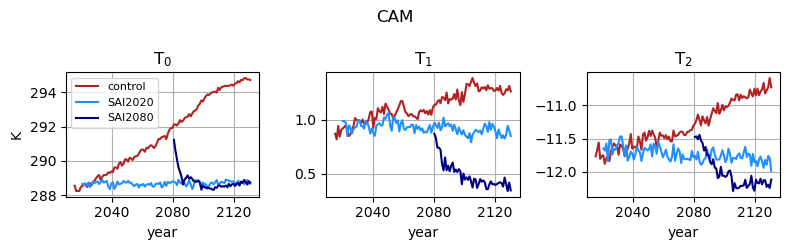

In [8]:
# cols = ['orangered','dodgerblue']
cols = ['firebrick','dodgerblue','navy']
labels = list(T_cam.keys())
fig, ax = plt.subplots(1,3, figsize=(8,2.5), sharex=True)

for e,exp in enumerate(T_cam):
    (T_cam[exp]['T0']).plot(ax=ax[0], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T1']).plot(ax=ax[1], label=labels[e], c=cols[e])
    
for e,exp in enumerate(T_cam):
    (T_cam[exp]['T2']).plot(ax=ax[2], label=labels[e], c=cols[e])

ax[0].set_title(r'T$_0$')
ax[1].set_title(r'T$_1$')
ax[2].set_title(r'T$_2$')
ax[0].set_ylabel('K')
ax[0].legend(prop={'size':8})
for axi in ax:
    axi.grid()
    axi.set_xlabel('year')
fig.suptitle('CAM')
plt.tight_layout()
plt.show()

In [9]:
%%time
var = 'TREFHT'
tslice1 = slice('2020','2040')
tslice2 = slice('2100','2130')
da1 = (cam['SAI2020'][var].sel(time=tslice2).mean('time')
       -cam['control'][var].sel(time=tslice1).mean('time')).compute()
da2 = (cam['SAI2080'][var].sel(time=tslice2).mean('time')
       -cam['control'][var].sel(time=tslice1).mean('time')).compute()
da3 = (cam['control'][var].sel(time=tslice2).mean('time')
       -cam['control'][var].sel(time=tslice1).mean('time')).compute()
da4 = {'SAI2020':da1.mean('lon'), 'SAI2080':da2.mean('lon'), 'control':da3.mean('lon')}

CPU times: user 3.21 s, sys: 179 ms, total: 3.38 s
Wall time: 6.7 s


Text(0.5, 0.98, '$\\Delta$T (2100-2130) - (2020-2040)')

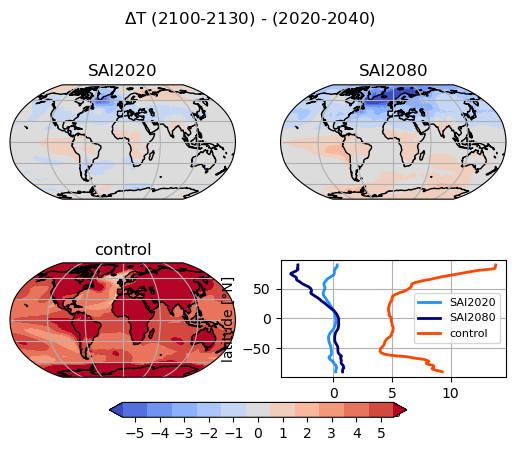

In [10]:
cfkwargs = {'transform':ccrs.PlateCarree(), 'levels':np.linspace(-5.5,5.5,12), 'extend':'both', 'cmap':'coolwarm', 'add_colorbar':False}
cols = ['dodgerblue','navy','orangered']
fig, axs = plt.subplots(2,2, subplot_kw={'projection':ccrs.Robinson()})
fig.delaxes(axs[1,1])
axs[1,1] = fig.add_subplot(2,2,4)

p1 = da1.plot.contourf(ax=axs[0,0], **cfkwargs)
p2 = da2.plot.contourf(ax=axs[0,1], **cfkwargs)
p3 = da3.plot.contourf(ax=axs[1,0], **cfkwargs)
for i,(k,v) in enumerate(da4.items()):
    v.plot(ax=axs[1,1], y='lat', label=k, c=cols[i], lw=2)

axs[0,0].set_title('SAI2020') 
axs[0,1].set_title('SAI2080')
axs[1,0].set_title('control')    
axs[1,1].set_xlabel('°C')
axs[1,1].set_ylabel('latitude [°N]')
axs[1,1].grid()
axs[1,1].legend(prop={'size':8})

for ax in axs.flatten()[:3]:
    ax.gridlines()
    ax.coastlines()

cb = fig.colorbar(p2, ax=axs[1,:], orientation='horizontal', shrink=.6)
cb.ax.set_xticks(range(-5,6))
cb.ax.set_xticks([], minor=True)
fig.suptitle(rf"$\Delta$T ({tslice2.start}-{tslice2.stop}) - ({tslice1.start}-{tslice1.stop})")
